In [133]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

In [134]:
os.listdir("/kaggle/input/kdd-cup-1999-data")

['kddcup.data.gz',
 'kddcup.data',
 'kddcup.testdata.unlabeled',
 'training_attack_types',
 'kddcup.data.corrected',
 'kddcup.newtestdata_10_percent_unlabeled.gz',
 'corrected',
 'kddcup.testdata.unlabeled.gz',
 'kddcup.testdata.unlabeled_10_percent',
 'corrected.gz',
 'kddcup.newtestdata_10_percent_unlabeled',
 'kddcup.data_10_percent.gz',
 'kddcup.names',
 'kddcup.data_10_percent_corrected',
 'typo-correction.txt',
 'kddcup.data_10_percent',
 'kddcup.testdata.unlabeled_10_percent.gz']

In [135]:
!cat /kaggle/input/kdd-cup-1999-data/kddcup.names

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: con

In [136]:
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
             'dst_bytes','land', 'wrong_fragment', 'urgent', 'hot', 
             'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
             'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
             'num_access_files', 'num_outbound_cmds', 'is_host_login', 
             'is_guest_login', 'count', 'srv_count', 'serror_rate', 
             'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
             'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
             'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
             'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
             'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
             'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
             'dst_host_srv_rerror_rate', 'label']

In [137]:
df = pd.read_csv('/kaggle/input/kdd-cup-1999-data/kddcup.data.gz', names=col_names)

In [138]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [139]:
df.shape

(4898431, 42)

In [140]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [141]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [142]:
df['label'].value_counts()

label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64

In [143]:
df['label'].nunique()

23

In [144]:
num_cols = df._get_numeric_data().columns

cate_cols = list(set(df.columns)-set(num_cols))

cate_cols

['service', 'protocol_type', 'label', 'flag']

In [145]:
df[cate_cols]

,service,protocol_type,label,flag
0,http,tcp,normal.,SF
1,http,tcp,normal.,SF
2,http,tcp,normal.,SF
3,http,tcp,normal.,SF
4,http,tcp,normal.,SF
...,...,...,...,...
4898426,http,tcp,normal.,SF
4898427,http,tcp,normal.,SF
4898428,http,tcp,normal.,SF
4898429,http,tcp,normal.,SF


In [146]:
# Make a copy of the initial dataframe so we can use different approach later
init_df = df.copy()

In [147]:
for category in cate_cols:
    print(df[category].value_counts())

service
ecr_i        2811660
private      1100831
http          623091
smtp           96554
other          72653
              ...   
tftp_u             3
harvest            2
aol                2
http_8001          2
http_2784          1
Name: count, Length: 70, dtype: int64
protocol_type
icmp    2833545
tcp     1870598
udp      194288
Name: count, dtype: int64
label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.         

In [148]:
category_mapping = {}
# Convert the non numerical values into numeric values via categorization e.g. TCP - 1, UDP -2 ...
for category in cate_cols:
    labels, unique_values = pd.factorize(df[category])
    df[category] = labels
    category_mapping[category] = dict(zip(set(unique_values), set(labels)))

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,0,0,0,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0


In [149]:
category_mapping

{'service': {'shell': 0,
  'exec': 1,
  'nnsp': 2,
  'http_8001': 3,
  'nntp': 4,
  'X11': 5,
  'other': 6,
  'IRC': 7,
  'rje': 8,
  'discard': 9,
  'daytime': 10,
  'gopher': 11,
  'efs': 12,
  'urh_i': 13,
  'ftp': 14,
  'time': 15,
  'ldap': 16,
  'ecr_i': 17,
  'domain': 18,
  'printer': 19,
  'hostnames': 20,
  'uucp_path': 21,
  'telnet': 22,
  'eco_i': 23,
  'domain_u': 24,
  'urp_i': 25,
  'courier': 26,
  'bgp': 27,
  'smtp': 28,
  'name': 29,
  'http': 30,
  'echo': 31,
  'supdup': 32,
  'pop_3': 33,
  'uucp': 34,
  'pop_2': 35,
  'iso_tsap': 36,
  'kshell': 37,
  'ftp_data': 38,
  'ntp_u': 39,
  'csnet_ns': 40,
  'netbios_ssn': 41,
  'tftp_u': 42,
  'auth': 43,
  'ssh': 44,
  'aol': 45,
  'red_i': 46,
  'pm_dump': 47,
  'netbios_dgm': 48,
  'link': 49,
  'login': 50,
  'klogin': 51,
  'vmnet': 52,
  'harvest': 53,
  'whois': 54,
  'sql_net': 55,
  'sunrpc': 56,
  'tim_i': 57,
  'mtp': 58,
  'imap4': 59,
  'http_2784': 60,
  'Z39_50': 61,
  'remote_job': 62,
  'netstat': 63,

In [150]:
for category in cate_cols:
    print(df[category].value_counts())

service
9     2811660
12    1100831
0      623091
1       96554
10      72653
       ...   
66          3
64          2
65          2
67          2
63          1
Name: count, Length: 70, dtype: int64
protocol_type
2    2833545
0    1870598
1     194288
Name: count, dtype: int64
label
5     2807886
4     1072017
0      972781
15      15892
10      12481
9       10413
17       2316
13       2203
20       1020
8         979
7         264
6          53
1          30
11         21
19         20
14         12
22         10
2           9
12          8
18          7
16          4
3           3
21          2
Name: count, dtype: int64
flag
0     3744328
7      869829
5      268874
8        8094
6        5344
10       1040
2         532
1         161
9         122
4          57
3          50
Name: count, dtype: int64


<Axes: >

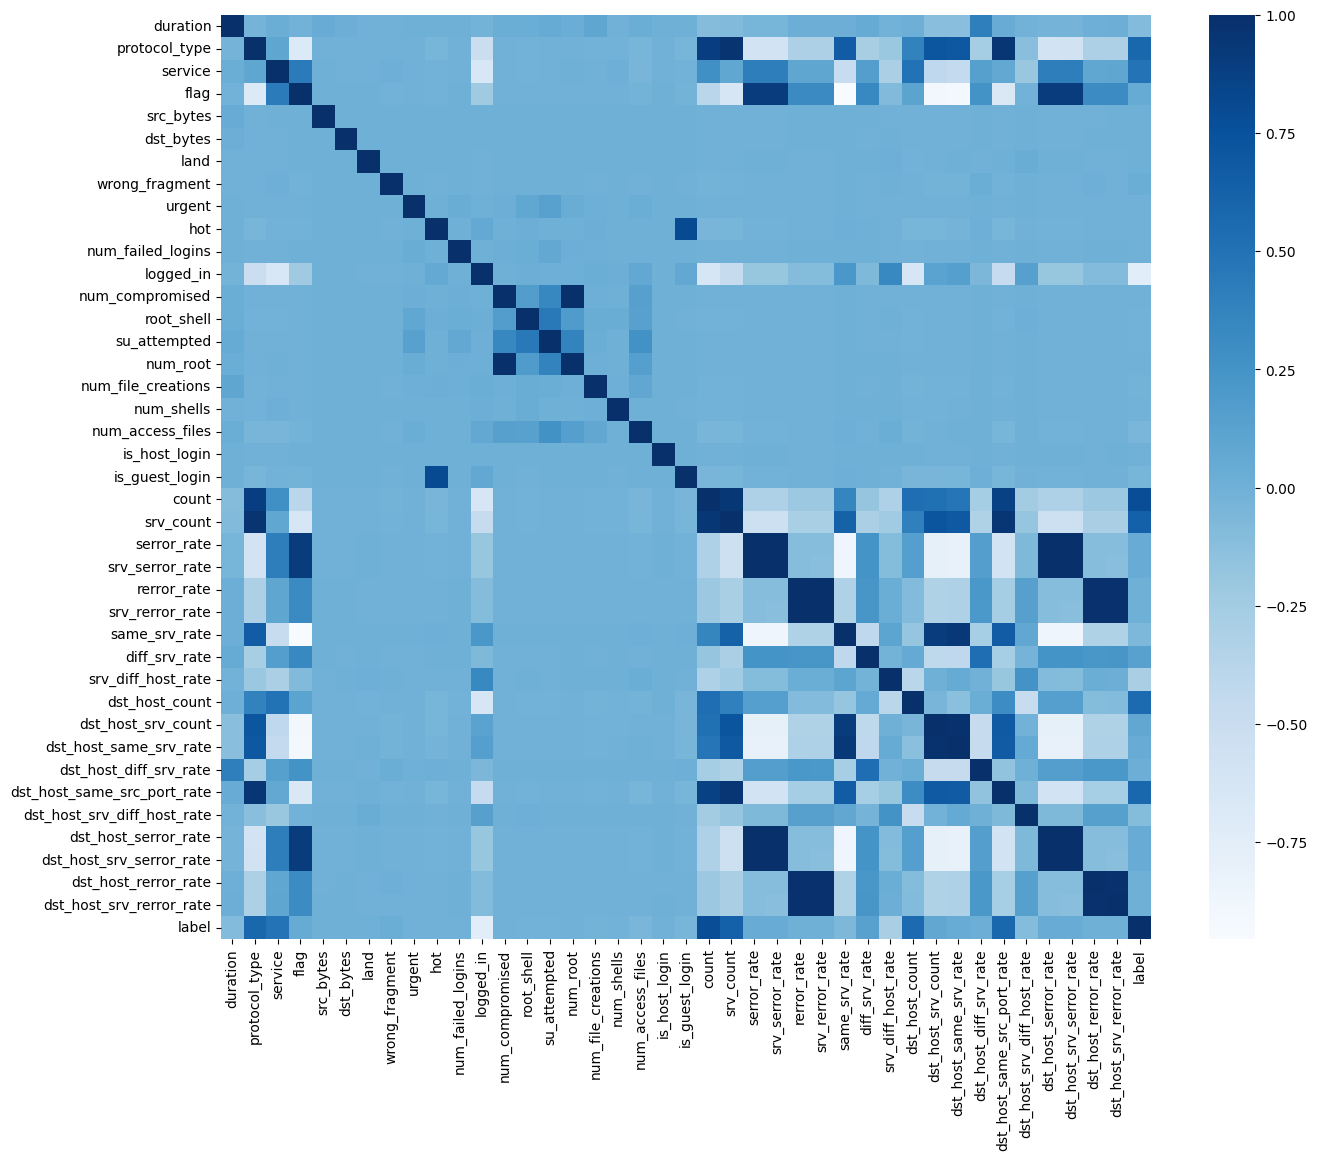

In [151]:
df = df[[col for col in df if df[col].nunique() > 1]]# keep columns where there are more than 1 unique values

corr = df.corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr, cmap='Blues')

In [152]:
X = df.drop('label',axis=1).values
y = df['label'].values
X,y

(array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ]]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [153]:
X[0], y[0]

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1500e+02,
        4.5076e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 0)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [155]:
X_train, X_test, y_train, y_test = torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test)